In [6]:
import igraph
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pynauty
from scipy.linalg import ishermitian
from sympy.combinatorics import Permutation, PermutationGroup

from qlinks.model.spin1_xy_model_1d import Spin1XYModel
from utils import setup_igraph

np.set_printoptions(threshold=np.inf)
pd.set_option("display.max_rows", None)

# Spin-1 XY model

* Size of Hilbert space: $3^n$


|  $n$  | 2  |  3  |  4  |  5  |  6  |  7  |  8  |  9  | 10  | 11  |
|:-----:|:--:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| $N_H$ |  9  | 27  | 81  | 243 | 729 |2187 |6561 |19683|59049|177147|

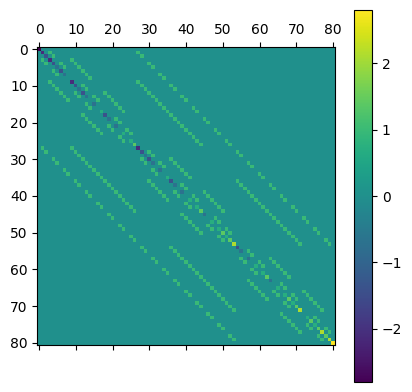

In [287]:
coup_j, coup_h, coup_d = (1, -0.7, 0)
model = Spin1XYModel(4, coup_j, coup_h, coup_d, periodic=True)
mat = model.hamiltonian.toarray()
assert ishermitian(mat)
evals, evecs = np.linalg.eigh(mat)

plt.matshow(mat)
plt.colorbar()

In [288]:
model.basis

,0,1,2,3
0,1,1,1,1
1,1,1,1,0
2,1,1,1,-1
3,1,1,0,1
4,1,1,0,0
5,1,1,0,-1
6,1,1,-1,1
7,1,1,-1,0
8,1,1,-1,-1
9,1,0,1,1


In [289]:
evecs_df = pd.DataFrame.from_dict(
    {
        "eval": evals,
        "kin": [(evec.T @ model.kinetic_term @ evec).item() for evec in evecs.T],
        "pot": [(evec.T @ model.potential_term @ evec).item() for evec in evecs.T],
        "pot2": [(evec.T @ model.potential_term2 @ evec).item() for evec in evecs.T],
        # "kin^2": [(evec.T @ model.kinetic_term @ model.kinetic_term @ evec).item() for evec in evecs.T],
        # "pot^2": [(evec.T @ model.potential_term @ model.potential_term @ evec).item() for evec in evecs.T],
    }
)
evecs_df[evecs_df["kin"].abs() < 1e-12]

,eval,kin,pot,pot2
9,-2.800000e+00,0.000000e+00,4.000000e+00,4.000000
12,-2.100000e+00,4.325189e-32,3.000000e+00,3.000000
13,-2.100000e+00,-5.148949e-31,3.000000e+00,3.000000
21,-1.400000e+00,-1.117686e-30,2.000000e+00,3.733333
22,-1.400000e+00,-1.632513e-17,2.000000e+00,2.006984
23,-1.400000e+00,-1.486638e-27,2.000000e+00,3.523126
24,-1.400000e+00,2.582114e-17,2.000000e+00,2.069890
25,-7.000000e-01,1.265810e-18,1.000000e+00,2.270999
26,-7.000000e-01,-3.328540e-18,1.000000e+00,2.262632
27,-7.000000e-01,1.047637e-17,1.000000e+00,2.792752


In [290]:
3 ** model.n - np.linalg.matrix_rank(model.kinetic_term.toarray())

35

(array([ 4,  6, 10, 12, 28, 30, 36, 54]),)

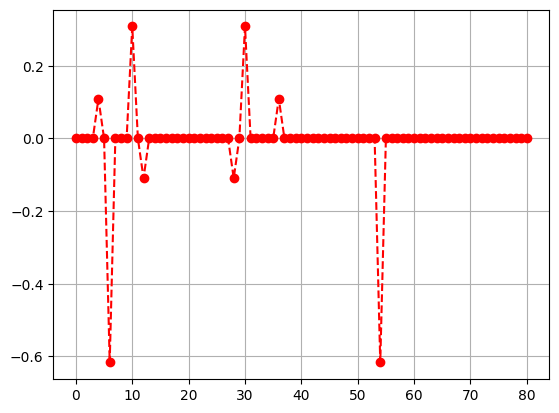

In [299]:
i = 23
plt.plot(evecs[:, i].T, linestyle="--", marker="o", color="red")
plt.grid()
np.where(np.abs(evecs[:, i]) > 0.05)

In [293]:
g = nx.from_scipy_sparse_array(model.kinetic_term)
ig = igraph.Graph.from_networkx(g)

ntg = pynauty.Graph(
    ig.vcount(),
    directed=True,
    adjacency_dict=nx.to_dict_of_lists(g),
)
aut_gp = pynauty.autgrp(ntg)[0]

perm_gp = PermutationGroup([Permutation(p) for p in aut_gp])

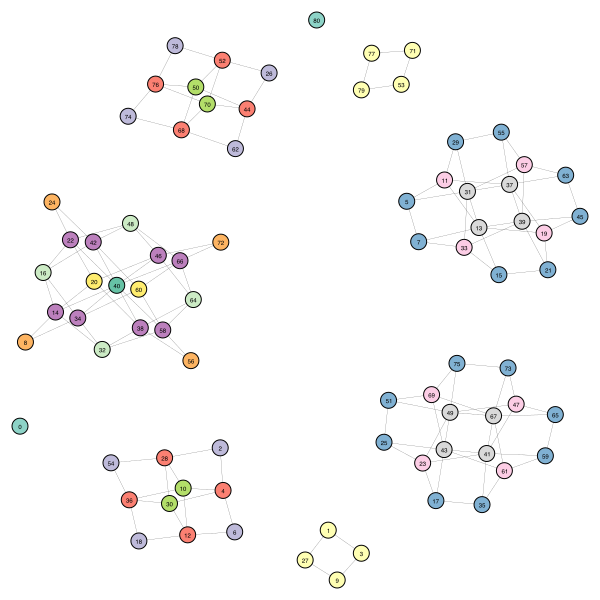

In [294]:
g = nx.from_scipy_sparse_array(model.kinetic_term)

highlight = [
    # np.where(np.abs(evecs[:, 231]) > 1e-6)[0],
]
# highlight = list(aut.degree_partition.values())
highlight = perm_gp.orbits()
# highlight = list(nx.bipartite.sets(g))

# highlight_color = list(mcolors.TABLEAU_COLORS.values())
# highlight_color = list(mcolors.CSS4_COLORS.values())
cmap = plt.get_cmap('Set3')
highlight_color = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
cmap = plt.get_cmap('Set2')
highlight_color += [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
highlight_color *= 2000
# highlight_color = [
#     "dimgray",
#     "whitesmoke",
#     "deepskyblue",
#     "yellowgreen",
#     "aqua",
#     "pink",
#     "tomato",
#     "royalblue",
#     "blueviolet",
#     "cornflowerblue",
#     "limegreen",
# ]

ig = setup_igraph(g, highlight, highlight_color)

degree = np.array(list(dict(g.degree).values()))
# (bipartite, types) = ig.is_bipartite(return_types=True)
# nodes = [int(n) for n in list(sub_sub_ig.vs["label"])]
# outer_boundary = list(nx.node_boundary(g, nodes))
# sub_ig = ig.induced_subgraph(np.append(nodes, outer_boundary))

# sub_ig = ig.induced_subgraph(np.where(degree == 8)[0])
# fig, ax = plt.subplots(figsize=(6, 6), facecolor="white")
igraph.plot(
    ig,
    # layout=ig.layout_kamada_kawai(),
    # layout=ig.layout_reingold_tilford(root=[0, 25, 50, 75]),
    # layout=ig.layout_bipartite(types=types),
    vertex_size=16,
    vertex_label_size=6,
    # vertex_label_dist=1.5,
    edge_width=0.2,
    # edge_color="darkgray",
    # target="qdm_subgraph_4x4.svg"
)

In [301]:
sub_components = ig.connected_components(mode="weak")

for i, c in enumerate(sub_components):
    mat = nx.to_numpy_array(ig.subgraph(c).to_networkx())
    print(repr(mat))
    # print(i, mat.shape[0], mat.shape[0] - np.linalg.matrix_rank(mat), nx.is_bipartite(ig.subgraph(c).to_networkx()))

array([[0.]])
array([[0., 1., 0., 1.],
       [1., 0., 1., 0.],
       [0., 1., 0., 1.],
       [1., 0., 1., 0.]])
array([[0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 1., 1., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0., 1., 0., 1., 0.],
       [0., 0., 1., 1., 0., 1., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 1., 0.],
       [1., 0., 0., 1., 0., 0., 0., 1., 0., 1.],
       [0., 1., 0., 0., 1., 0., 1., 0., 1., 0.],
       [0., 0., 0., 1., 0., 1., 0., 1., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 1., 0.]])
array([[0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0

In [302]:
m = np.array([[0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 1., 1., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0., 1., 0., 1., 0.],
       [0., 0., 1., 1., 0., 1., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 1., 0.],
       [1., 0., 0., 1., 0., 0., 0., 1., 0., 1.],
       [0., 1., 0., 0., 1., 0., 1., 0., 1., 0.],
       [0., 0., 0., 1., 0., 1., 0., 1., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 1., 0.]])
m2 = m @ m

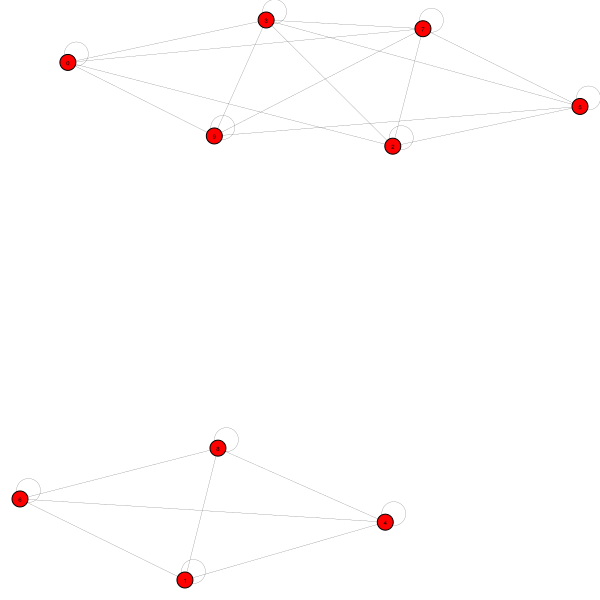

In [303]:
g = nx.from_numpy_array(m2)
ig = setup_igraph(g)
igraph.plot(
    ig,
    vertex_size=16,
    vertex_label_size=6,
    edge_width=0.2,
)

In [304]:
sub_components = ig.connected_components(mode="weak")

for i, c in enumerate(sub_components):
    mat = nx.to_numpy_array(ig.subgraph(c).to_networkx())
    # print(repr(mat))
    print(i, mat.shape[0], mat.shape[0] - np.linalg.matrix_rank(mat), nx.is_bipartite(ig.subgraph(c).to_networkx()))

0 6 3 False
1 4 1 False
